# Training MobileNet

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


X_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_train_256x192.npy")
y_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/train_labels.npy")

X_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_val_256x192.npy")
y_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/val_labels.npy")

X_train.shape, X_val.shape
y_train.shape, y_val.shape

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
# y_train.shape, y_val.shape


pretrained_model = MobileNet(input_shape=(192, 256, 3), include_top=False,weights='imagenet')

for layer in pretrained_model.layers:
    print(layer.name)
    layer.trainable = False
    
# print(len(pretrained_model.layers))

/tmp/ipykernel_34314/4031347438.py:33: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = MobileNet(input_shape=(192, 256, 3), include_top=False,weights='imagenet')
2025-05-10 10:43:21.143464: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


input_layer
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
con

In [3]:
last_layer = pretrained_model.get_layer('conv_pw_13_relu')
print('Last layer output shape:', last_layer.output.shape)
last_output = last_layer.output


Last layer output shape: (None, 6, 8, 1024)


In [4]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

model = Model(pretrained_model.input, x)
#change epsilon from NONE to 1e-7, this helps not to divide by xero
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

train_datagenerator = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagenerator.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)


/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [5]:
batch_size = 64 
epochs = 3
history = model.fit(train_datagenerator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    validation_steps=(X_val.shape[0] // batch_size))                    


/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.5235 - loss: 3.0011 - precision: 0.5376 - recall: 0.5065 - val_accuracy: 0.6763 - val_loss: 1.1596 - val_precision: 0.7332 - val_recall: 0.6562
Epoch 2/3
  1/126 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.6875 - loss: 0.9142 - precision: 0.7500 - recall: 0.6562

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6875 - loss: 0.9142 - precision: 0.7500 - recall: 0.6562 - val_accuracy: 0.6875 - val_loss: 1.1571 - val_precision: 0.7309 - val_recall: 0.6607
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6460 - loss: 1.1525 - precision: 0.7127 - recall: 0.5892 - val_accuracy: 0.6719 - val_loss: 1.0521 - val_precision: 0.7186 - val_recall: 0.6384


In [6]:
for layer in model.layers[:60]:
    layer.trainable = False

for layer in model.layers[60:]:
    layer.trainable = True      

# reconfiguring and compling model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])                      
              

In [8]:
# decreasing learning rate when model is stuck(not improving)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

batch_size = 64
epochs = 15
history = model.fit(train_datagenerator.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[lr_reduction])                                            
                           

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6644 - loss: 1.0736 - precision: 0.7607 - recall: 0.5907 - val_accuracy: 0.6607 - val_loss: 1.8271 - val_precision: 0.6720 - val_recall: 0.6585 - learning_rate: 1.0000e-04
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.6875 - loss: 0.9150 - precision: 0.8182 - recall: 0.5625 - val_accuracy: 0.6652 - val_loss: 1.7823 - val_precision: 0.6705 - val_recall: 0.6585 - learning_rate: 1.0000e-04
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.6923 - loss: 0.8711 - precision: 0.8323 - recall: 0.5960 - val_accuracy: 0.6406 - val_loss: 1.2114 - val_precision: 0.6715 - val_recall: 0.6250 - learning_rate: 1.0000e-04
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7031 - loss: 0.7546 - precision: 0.8696 - recall: 0.6250 - val_accuracy: 0.6629 - val_loss: 1.1469 - val_precision: 0.6969 - val_recall: 0.6518 - learning_rate: 1.0000e-04
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 242s

In [9]:
results = model.evaluate(X_val, y_val, verbose=1)
loss_val = results[0]
acc_val = results[1]
precision_val = results[2]
recall_val = results[3]

print("Validation: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (acc_val, loss_val, precision_val, recall_val))

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 466ms/step - accuracy: 0.7797 - loss: 0.5769 - precision: 0.8460 - recall: 0.7117
Validation: accuracy = 0.767184  ;  loss = 0.615042  ;  precision = 0.836461  ;  recall = 0.691796


# Testing MobileNet

In [10]:
X_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_test_256x192.npy")

y_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/test_labels.npy")
y_test = to_categorical(y_test)


results = model.evaluate(X_test, y_test, verbose=1)

# Unpack individual metrics from the results list
loss_test = results[0]
accuracy_test = results[1]
precision_test = results[2]
recall_test = results[3]

print("Test: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (accuracy_test, loss_test, precision_test, recall_test))

# loss_test, accuracy_test = model.evaluate(X_test, y_test,? verbose=1)
# print("Test: accuracy = %f  ;  loss = %f" % (accuracy_test, loss_test))

model.save("MobileNet.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - accuracy: 0.7657 - loss: 0.6146 - precision: 0.8509 - recall: 0.6918


Test: accuracy = 0.771457  ;  loss = 0.601509  ;  precision = 0.851942  ;  recall = 0.700599


Text(0.5, 1.0, 'Training and validation loss')

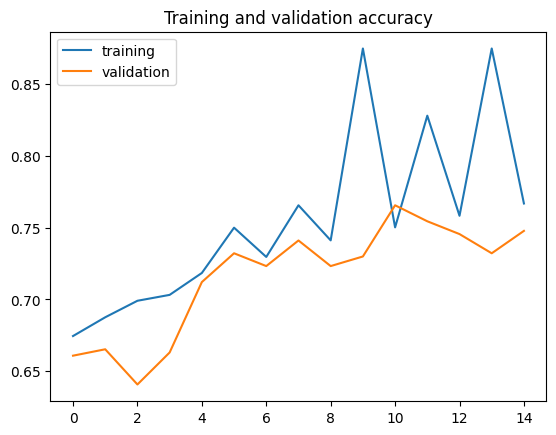

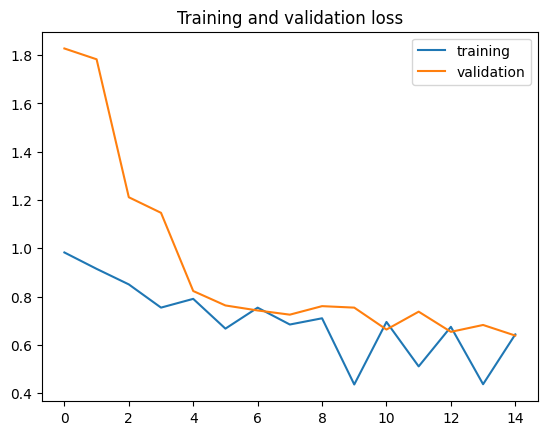

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="training")
plt.plot(epochs, val_acc, label="validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label="training")
plt.plot(epochs, val_loss, label="validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')
